# Analizaremos un dataset de vinos

Principales investigacion del dataset son:
1. Análisis exploratorio de datos
2. Análisis Outliers
3. Análisis de componentes principales
4. Predicción y selección de modelos


# 1. Análisis exploratorio de datos

In [974]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [975]:
%cd '/content/drive/My Drive/Notebook Colab/Base de datos/Casos Analizados/wine'
!ls

/content/drive/My Drive/Notebook Colab/Base de datos/Casos Analizados/wine
Description.txt  winequality-red.csv  winequality-white.csv


In [976]:
import numpy as np
import pandas as pd 
import os
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [977]:
data = pd.read_csv("winequality-red.csv", sep = ";")

In [978]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


verificamos la correlación para cada uno de los campos

In [979]:
data.groupby('quality').corr().unstack()

fixed acidity                               ...   alcohol                  
        fixed acidity volatile acidity citric acid  ...        pH sulphates alcohol
quality                                             ...                            
3                 1.0        -0.578216    0.962292  ...  0.850144 -0.416332     1.0
4                 1.0        -0.246384    0.546197  ...  0.521829 -0.137167     1.0
5                 1.0        -0.173671    0.626558  ...  0.237317 -0.015282     1.0
6                 1.0        -0.264029    0.674388  ...  0.215453 -0.046248     1.0
7                 1.0        -0.251427    0.734071  ...  0.314296 -0.049359     1.0
8                 1.0        -0.402157    0.886495  ...  0.698383 -0.212935     1.0

[6 rows x 121 columns]

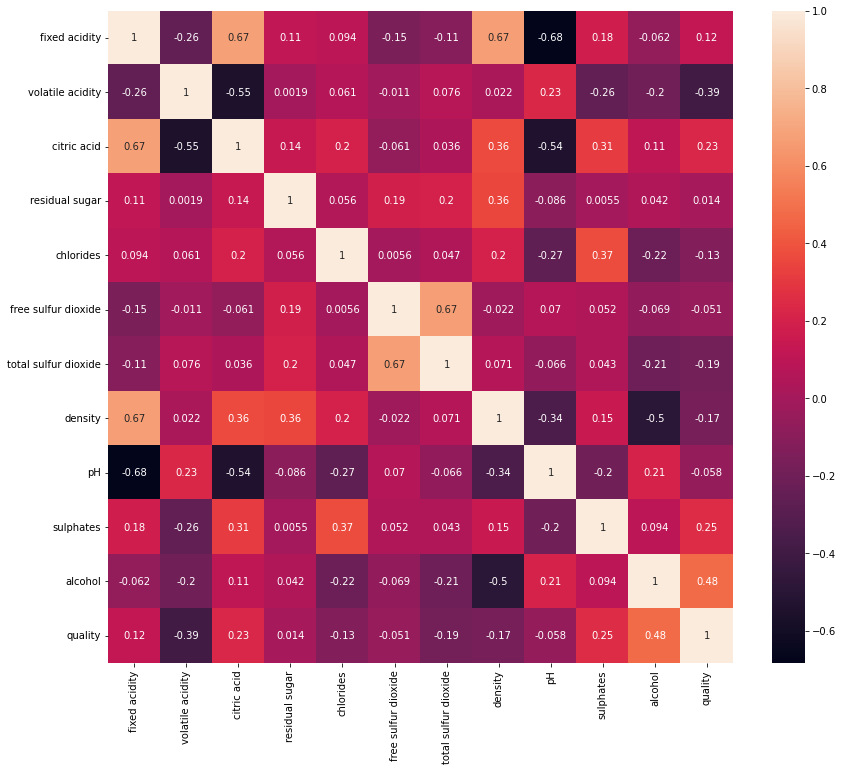

In [980]:
corelation=data.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corelation,annot=True)

In [981]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [982]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


¿Hay datos perdidos?

In [983]:
data.quality = pd.to_numeric(data.quality, errors='coerce')
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

¿Cuales son los datos de la columna 'quality'?

In [984]:
data['quality'].unique()

array([5, 6, 7, 4, 8, 3])

# 2. Analisis Outliers

Utilizando el diagrama de pares de Seaborn revisamos la correlación entre las variables

* Sin correlación entre los campos como se ve en el diagrama de pares

In [985]:
#sns.pairplot(data)

* Recuento de la variable objetivo

In [986]:
from collections import Counter
Counter(data['quality'])

Counter({3: 10, 4: 53, 5: 681, 6: 638, 7: 199, 8: 18})

* Grafica de la variable de Objetivo

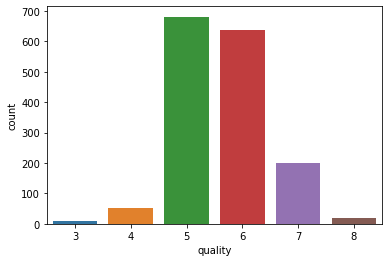

In [987]:
sns.countplot(x='quality', data=data)

# Histograma, un gráfico Q-Q plot y boxplot

* La variable de Objetivo es Calidad.
* Entonces realizare histograma, un gráfico Q-Q plot de las columnas
* y un boxplot de cada columna contra la variable Objetivo del dataset

In [988]:
def diagnostic_plots(df, variable):

    # tamaño gráfica
    plt.figure(figsize=(16, 4))

    # histograma
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # gráfica Q-Q 
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.ylabel('quantiles')

    # diagrama de caja
    plt.subplot(1, 3, 3)
    sns.boxplot('quality', y=df[variable], data = data)
    plt.title('Boxplot')

    plt.show()

<Figure size 2160x6480 with 0 Axes>

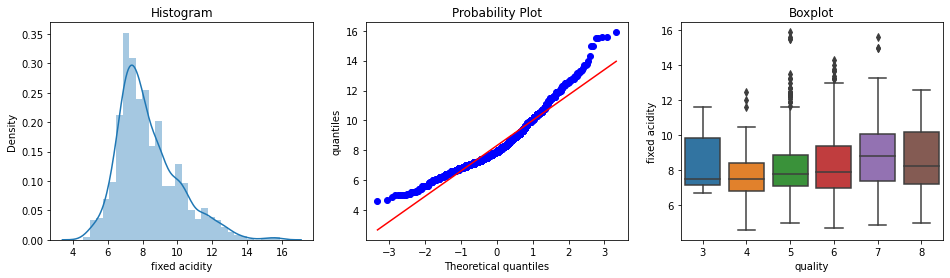

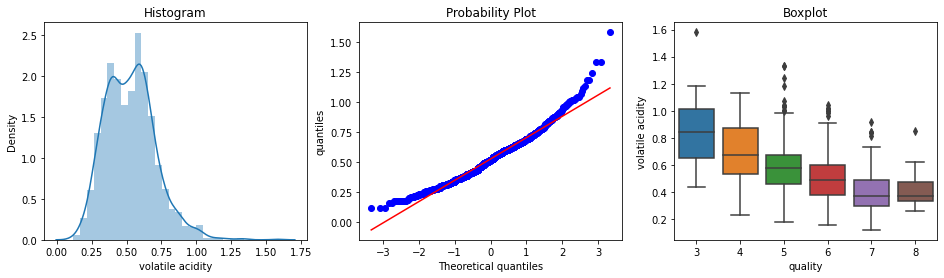

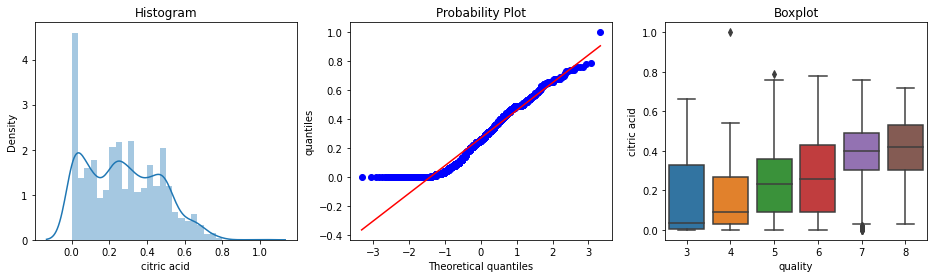

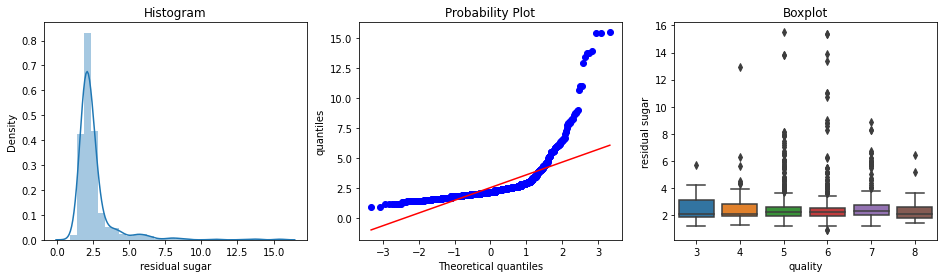

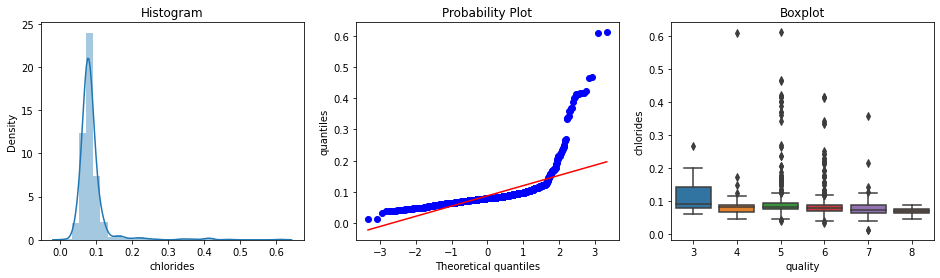

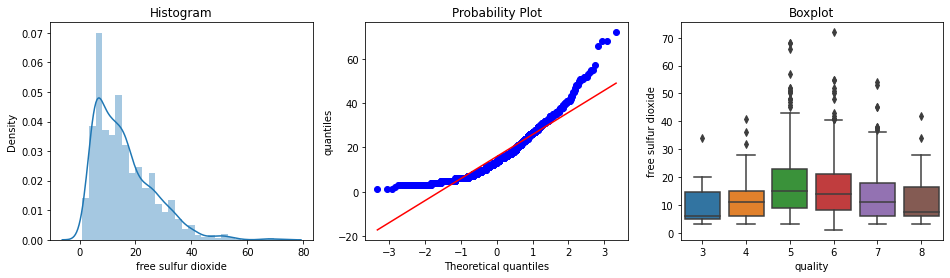

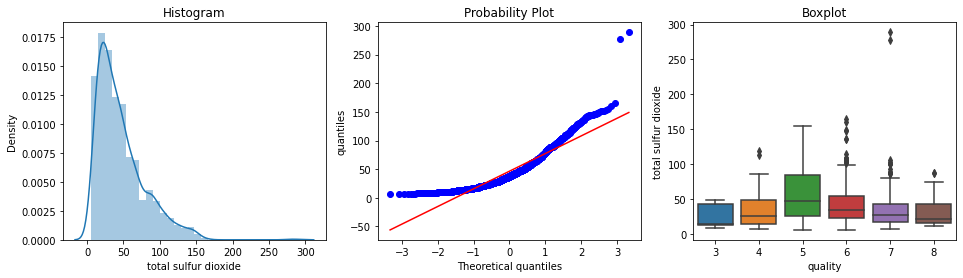

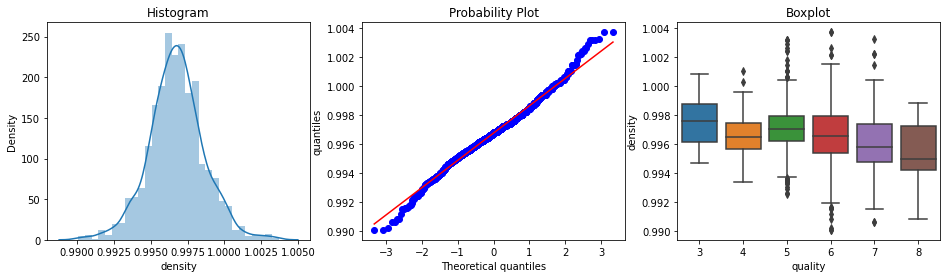

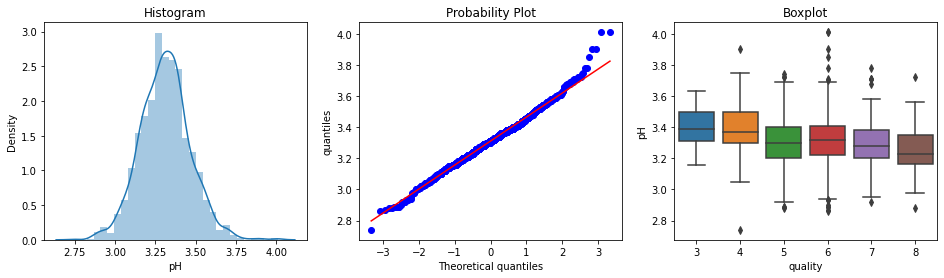

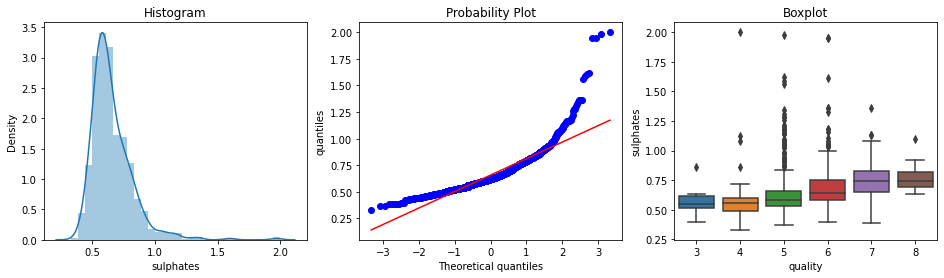

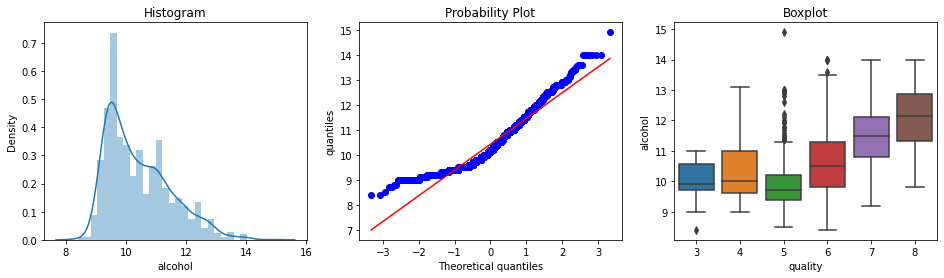

In [989]:
## https://www.youtube.com/watch?v=m_no9B42878
## ¿Cómo hacer varias gráficas en una sola ventana? | Subplot |Matplotlib | Python | ¡Muy Básico!

ncomp = ['fixed acidity', 'volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates', 'alcohol']
plt.figure(figsize=(30,90))

for x in range(len(ncomp)):
  h=diagnostic_plots(data, ncomp[x])



# 2.1 Identificar los Outliers

In [990]:
def find_skewed_boundaries(df, variable, distance):

    # Calcular los límites para los valores extremos

    # distance es un argumento de la función que da la opción de 
    # estimar 1.5 o 3 veces el IQR para calcular los límites

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

---
Considerar outliers o valores atípicos de **fixed acidity**
* Valores mayores a 12.34
* Valores menores a 3.95

In [991]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'fixed acidity', 1.5)
upper_boundary, lower_boundary

(12.349999999999998, 3.95)

In [992]:
print('Número de vinos: {}'.format(len(data)))

print('fixed acidity de 12.34 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['fixed acidity'] > upper_boundary])))

print('fixed acidity de 3.95 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['fixed acidity'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['fixed acidity'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['fixed acidity'] < lower_boundary]) / len(data)))

Número de vinos: 1599
fixed acidity de 12.34 (extremo derecho de los valores atípicos): 49
fixed acidity de 3.95 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.030644152595372107
% extremo izquierdo de los valores atípicos: 0.0


---
Considerar outliers o valores atípicos de **volatile acidity**
* Valores mayores a 1.015
* Valores menores a 0.015

In [993]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'volatile acidity', 1.5)
upper_boundary, lower_boundary

(1.0150000000000001, 0.015000000000000013)

In [994]:
print('Número de vinos: {}'.format(len(data)))

print('acidez volátil de 1.06 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['volatile acidity'] > upper_boundary])))

print('acidez volátil de 1.06 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['volatile acidity'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['volatile acidity'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['volatile acidity'] < lower_boundary]) / len(data)))

Número de vinos: 1599
acidez volátil de 1.06 (extremo derecho de los valores atípicos): 19
acidez volátil de 1.06 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.011882426516572859
% extremo izquierdo de los valores atípicos: 0.0


---
Considerar outliers o valores atípicos de **citric acid**
* Valores mayores a 0.914
* Valores menores a 0

In [995]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'citric acid', 1.5)
upper_boundary, lower_boundary

(0.9149999999999999, -0.4049999999999999)

In [996]:
print('Número de vinos: {}'.format(len(data)))

print('ácido cítrico de 0.8 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['citric acid'] > upper_boundary])))

print('ácido cítrico de 1.06 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['citric acid'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['citric acid'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['citric acid'] < lower_boundary]) / len(data)))

Número de vinos: 1599
ácido cítrico de 0.8 (extremo derecho de los valores atípicos): 1
ácido cítrico de 1.06 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.0006253908692933083
% extremo izquierdo de los valores atípicos: 0.0


---
Considerar outliers o valores atípicos de **residual sugar**
* Valores mayores a 3.65
* Valores menores a 0.8499

In [997]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'residual sugar', 1.5)
upper_boundary, lower_boundary

(3.6500000000000004, 0.8499999999999996)

In [998]:
print('Número de vinos: {}'.format(len(data)))

print('azúcar residual de 3.65 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['residual sugar'] > upper_boundary])))

print('azúcar residual de 0.8499 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['residual sugar'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['residual sugar'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['residual sugar'] < lower_boundary]) / len(data)))

Número de vinos: 1599
azúcar residual de 3.65 (extremo derecho de los valores atípicos): 155
azúcar residual de 0.8499 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.0969355847404628
% extremo izquierdo de los valores atípicos: 0.0


---
Considerar outliers o valores atípicos de **chlorides**
* Valores mayores a 0.119
* Valores menores a 0.04

In [999]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'chlorides', 1.5)
upper_boundary, lower_boundary

(0.11999999999999998, 0.04000000000000002)

In [1000]:
print('Número de vinos: {}'.format(len(data)))

print('cloruros de 0.119 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['chlorides'] > upper_boundary])))

print('cloruros de 0.04 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['chlorides'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['chlorides'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['chlorides'] < lower_boundary]) / len(data)))

Número de vinos: 1599
cloruros de 0.119 (extremo derecho de los valores atípicos): 103
cloruros de 0.04 (extremo izquierdo de los valores atípicos): 9

% extremo derecho de los valores atípicos: 0.06441525953721075
% extremo izquierdo de los valores atípicos: 0.005628517823639775


---
Considerar outliers o valores atípicos de **free sulfur dioxide**
* Valores mayores a 42
* Valores menores a 0

In [1001]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'free sulfur dioxide', 1.5)
upper_boundary, lower_boundary

(42.0, -14.0)

In [1002]:
print('Número de vinos: {}'.format(len(data)))

print('free sulfur dioxide de 42 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['free sulfur dioxide'] > upper_boundary])))

print('free sulfur dioxide de 0 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['free sulfur dioxide'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['free sulfur dioxide'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['free sulfur dioxide'] < lower_boundary]) / len(data)))

Número de vinos: 1599
free sulfur dioxide de 42 (extremo derecho de los valores atípicos): 30
free sulfur dioxide de 0 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.01876172607879925
% extremo izquierdo de los valores atípicos: 0.0


---
Considerar outliers o valores atípicos de **total sulfur dioxide**
* Valores mayores a 122
* Valores menores a 0

In [1003]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'total sulfur dioxide', 1.5)
upper_boundary, lower_boundary

(122.0, -38.0)

In [1004]:
print('Número de vinos: {}'.format(len(data)))

print('total sulfur dioxide de 122 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['total sulfur dioxide'] > upper_boundary])))

print('total sulfur dioxide de 0 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['total sulfur dioxide'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['total sulfur dioxide'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['total sulfur dioxide'] < lower_boundary]) / len(data)))

Número de vinos: 1599
total sulfur dioxide de 122 (extremo derecho de los valores atípicos): 55
total sulfur dioxide de 0 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.03439649781113196
% extremo izquierdo de los valores atípicos: 0.0


---
Considerar outliers o valores atípicos de **density**
* Valores mayores a 1
* Valores menores a 0.99

In [1005]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'density', 1.5)
upper_boundary, lower_boundary

(1.0011874999999997, 0.9922475000000002)

In [1006]:
print('Número de vinos: {}'.format(len(data)))

print('density de 1 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['density'] > upper_boundary])))

print('density de 0.99 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['density'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['density'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['density'] < lower_boundary]) / len(data)))

Número de vinos: 1599
density de 1 (extremo derecho de los valores atípicos): 24
density de 0.99 (extremo izquierdo de los valores atípicos): 21

% extremo derecho de los valores atípicos: 0.0150093808630394
% extremo izquierdo de los valores atípicos: 0.013133208255159476


---
Considerar outliers o valores atípicos de **pH**
* Valores mayores a 3.684
* Valores menores a 2.925

In [1007]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'pH', 1.5)
upper_boundary, lower_boundary

(3.6849999999999996, 2.925)

In [1008]:
print('Número de vinos: {}'.format(len(data)))

print('pH de 3.684 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['pH'] > upper_boundary])))

print('pH de 2.925 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['pH'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['pH'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['pH'] < lower_boundary]) / len(data)))

Número de vinos: 1599
pH de 3.684 (extremo derecho de los valores atípicos): 21
pH de 2.925 (extremo izquierdo de los valores atípicos): 14

% extremo derecho de los valores atípicos: 0.013133208255159476
% extremo izquierdo de los valores atípicos: 0.008755472170106316


---
Considerar outliers o valores atípicos de **sulphates**
* Valores mayores a 0.999
* Valores menores a 0.28

In [1009]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'sulphates', 1.5)
upper_boundary, lower_boundary

(0.9999999999999999, 0.28000000000000014)

In [1010]:
print('Número de vinos: {}'.format(len(data)))

print('sulphates de 0.999 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['sulphates'] > upper_boundary])))

print('sulphates de 0.28 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['sulphates'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['sulphates'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['sulphates'] < lower_boundary]) / len(data)))

Número de vinos: 1599
sulphates de 0.999 (extremo derecho de los valores atípicos): 59
sulphates de 0.28 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.03689806128830519
% extremo izquierdo de los valores atípicos: 0.0


---
Considerar outliers o valores atípicos de **alcohol**
* Valores mayores a 13.5
* Valores menores a 7.1

In [1011]:
upper_boundary, lower_boundary = find_skewed_boundaries(data, 'alcohol', 1.5)
upper_boundary, lower_boundary

(13.5, 7.1000000000000005)

In [1012]:
print('Número de vinos: {}'.format(len(data)))

print('alcohol de 13.5 (extremo derecho de los valores atípicos): {}'.format(
    len(data[data['alcohol'] > upper_boundary])))

print('alcohol de 7.1 (extremo izquierdo de los valores atípicos): {}'.format(
    len(data[data['alcohol'] < lower_boundary])))
print()
print('% extremo derecho de los valores atípicos: {}'.format(
    len(data[data['alcohol'] > upper_boundary]) / len(data)))

print('% extremo izquierdo de los valores atípicos: {}'.format(
    len(data[data['alcohol'] < lower_boundary]) / len(data)))

Número de vinos: 1599
alcohol de 13.5 (extremo derecho de los valores atípicos): 13
alcohol de 7.1 (extremo izquierdo de los valores atípicos): 0

% extremo derecho de los valores atípicos: 0.008130081300813009
% extremo izquierdo de los valores atípicos: 0.0


# 2.2 Conclusion Analisis Outliers

In [1013]:
outliers = pd.DataFrame({
    'Componentes' : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol'],
    '% de Extremo Derecho' : [0.03*100, 0.0118*100, 0.00062*100, 0.096*100 , 0.064*100, 0.018*100, 0.03*100, 0.015*100, 0.013*100, 0.03*100, 0.008*100],
    '% de Extremo Izquierdo' : [0, 0, 0, 0, 0.005*100, 0, 0, 0.013*100, 0.008*100, 0, 0]
})


#outliers.sort_values(by = '% de Extremo Derecho', ascending = False)
outliers

,Componentes,% de Extremo Derecho,% de Extremo Izquierdo
0,fixed acidity,3.000,0.0
1,volatile acidity,1.180,0.0
2,citric acid,0.062,0.0
3,residual sugar,9.600,0.0
4,chlorides,6.400,0.5
5,free sulfur dioxide,1.800,0.0
6,total sulfur dioxide,3.000,0.0
7,density,1.500,1.3
8,pH,1.300,0.8
9,sulphates,3.000,0.0


¿Que porcentaje tiene de Outliers el dataset?

In [1014]:
outliers['% de Extremo Derecho'].sum()+outliers['% de Extremo Izquierdo'].sum()

34.242

Descripcion general de los datos 

In [1015]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



1. boxplots muestra muchos valores atípicos para bastantes columnas. 
* acidez fija el 25% en 7,1 y 50% en 7,9. Tiene un 3% de Outliers.
* acidez volátil el 25% en 0.39 y 50% en 0.52. Tiene un 1% de Outliers.
* ácido cítrico - tiene distribucion uniforme, tiene distribucion 0 y 1. Tiene un 0.062% de Outliers
* azúcar residual el minimo 0.9, maximo 15 excesiva diferencia. Tiene un 9.6% de Outliers	
* cloruros - Mínimo - 0.012, máximo - 0.611 excesiva diferencia. tiene un 6.4% de Outliers.
* dióxido de azufre libre, minimo 1 y maximo 72 excesiva diferencia, tiene un 1.8% de Outliers.
* dióxido de azufre total minimo 6, maximo 289 excesiva diferencia, tiene un 6.4% de Outliers.
* densidad , 25% en 0.9956 y 50% en 0.9967, tiene un 1.5% de Outliers.
* pH  25% en 3.2 y 50% en 3.3, tiene un 1.3% de Outliers.
* Sulfato 25% en 0.55 y 50% en 0.62, tiene un 3% de Outliers.
* Alcohol 25% en 9.5 y 50% en 10.2, tiene un 0.8% de Outliers.
* total de outliers del dataset es de 31.64% distribuido en 11 componentes del vino

---

A continuación, crearemos una nueva columna llamada Revisión. 

Esta columna contendrá los valores de 1, 2 y 3.

* 1 - Muy Malo
* 2 - Promedio
* 3 - Excelente

Esto se dividirá de la siguiente manera.
* 1,2,3 -> Muy Malo
* 4,5,6,7 -> Promedio
* 8,9,10 -> Excelente

* Crea una lista vacía llamada Reseñas

In [1016]:
reviews = []
for i in data['quality']:
    if i >= 1 and i <= 3:
        reviews.append('1')
    elif i >= 4 and i <= 7:
        reviews.append('2')
    elif i >= 8 and i <= 10:
        reviews.append('3')
data['Reviews'] = reviews


ver datos finales

In [1017]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Reviews'],
      dtype='object')

In [1018]:
data['Reviews'].unique()

array(['2', '3', '1'], dtype=object)

In [1019]:
Counter(data['Reviews'])

Counter({'1': 10, '2': 1571, '3': 18})

In [1020]:
data['Reviews'].value_counts(normalize = True)*100

2    98.248906
3     1.125704
1     0.625391
Name: Reviews, dtype: float64

Existen

1.- Calidad mala 10 vinos. correspondiente a un 0.6%

2.- Calidad promedio 1571 vinos. correspondiente a un 98%

3.- Calidad bueno 18 vinos. correspondiente a un 1.1%


---


* Dividir las variables x e y
* para tener datos de entrenamientos y datos de prueba para los modelos de marchine learning

In [1021]:
x = data.iloc[:,:11]
y = data['Reviews']

Variables predictoras 'x'
* 11 componentes del vino

In [1022]:
x.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5


Variables a predecir 'y'
* Variable Objetivo 'y' correspondiente a 'Reviews'

In [1023]:
y.head(10)

0    2
1    2
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: Reviews, dtype: object

# 3. Análisis de componentes principales
* PCA sirve para reducir dimensionalidad y busca la mejor distribucion de los datos en términos de mínimos cuadrados.
* Es decir, con el Dataset voy a intentar juntar y combinar de algún modo las variables que se parezcan y quedarme con el minimo numero de variables que explican el dataset.
* Ahora escale los datos usando StandardScaler para PCA

In [1024]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

ver las características escaladas

In [1025]:
print(x)

[[-0.52835961  0.96187667 -1.39147228 ...  1.28864292 -0.57920652
  -0.96024611]
 [-0.29854743  1.96744245 -1.39147228 ... -0.7199333   0.1289504
  -0.58477711]
 [-0.29854743  1.29706527 -1.18607043 ... -0.33117661 -0.04808883
  -0.58477711]
 ...
 [-1.1603431  -0.09955388 -0.72391627 ...  0.70550789  0.54204194
   0.54162988]
 [-1.39015528  0.65462046 -0.77526673 ...  1.6773996   0.30598963
  -0.20930812]
 [-1.33270223 -1.21684919  1.02199944 ...  0.51112954  0.01092425
   0.54162988]]


Proceda a realizar PCA


In [1026]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(x)

* trazar la gráfica para encontrar los componentes principales

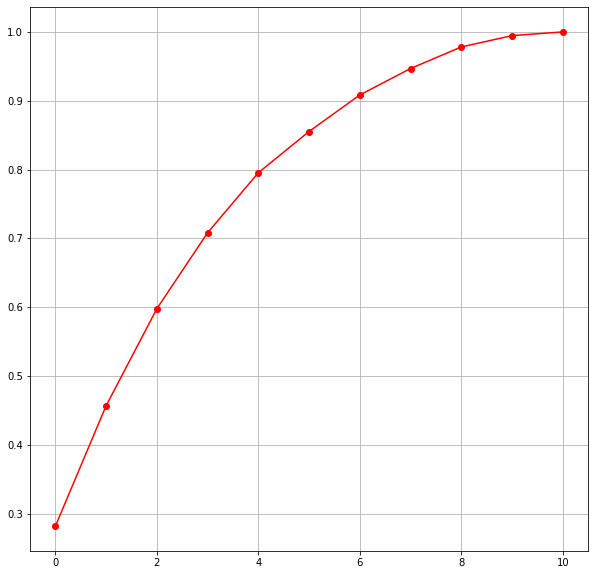

In [1027]:
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()

* Teniamos en el dataset original 11 componentes del vino
* AS según el gráfico, podemos ver que los 8 componentes principales atribuyen el 90% de la variación en los datos.
* Elegiremos los primeros 8 componentes para nuestra predicción.

In [1028]:
pca_new = PCA(n_components=8)
x_new = pca_new.fit_transform(x)

In [1029]:
print(x_new)

[[-1.61952988  0.45095009 -1.77445415 ... -0.91392069 -0.16104319
  -0.28225828]
 [-0.79916993  1.85655306 -0.91169017 ...  0.92971392 -1.00982858
   0.76258697]
 [-0.74847909  0.88203886 -1.17139423 ...  0.40147313 -0.53955348
   0.59794606]
 ...
 [-1.45612897  0.31174559  1.12423941 ... -0.50640956 -0.23108221
   0.07938219]
 [-2.27051793  0.97979111  0.62796456 ... -0.86040762 -0.32148695
  -0.46887589]
 [-0.42697475 -0.53669021  1.6289552  ... -0.49615364  1.18913227
   0.04217568]]


# 3. Predicción y selección de modelos
* Divida los datos en datos de prueba y de tren



In [1030]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.25)

In [1031]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1199, 8)
(1199,)
(400, 8)
(400,)


# Probando Modelos
1. Regresión logística.
2. Árboles de decisión.
3. Naive Bayes.
4. Random Forests.
5. SVM.



#1. Regresión logística.


In [1032]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score #Matriz de confusion y score

In [1033]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)


In [1034]:
x_train.shape

(1199, 8)

In [1035]:
y_train.shape

(1199,)

imprimir matriz de confusión y puntuación de precisión
* 98.5% de puntuacion tiene el modelo logistico

In [1036]:
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print(lr_conf_matrix)
print(lr_acc_score*100)

[[  0   2   0]
 [  0 394   1]
 [  0   3   0]]
98.5


# 2. Arbol de decision

In [1037]:
from sklearn.tree import DecisionTreeClassifier

In [1038]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt_predict = dt.predict(x_test)

imprimir matriz de confusión y puntuación de precisión
* 97.5% de Puntuacion el Arbol de clasificacion

In [1039]:
dt_conf_matrix = confusion_matrix(y_test, dt_predict)
dt_acc_score = accuracy_score(y_test, dt_predict)
print(dt_conf_matrix)
print(dt_acc_score*100)

[[  1   1   0]
 [  2 389   4]
 [  0   3   0]]
97.5


# 3. Naive Bayes

In [1040]:
from sklearn.naive_bayes import GaussianNB

In [1041]:
nb = GaussianNB()
nb.fit(x_train,y_train)
nb_predict=nb.predict(x_test)

imprimir matriz de confusión y puntuación de precisión
* 98.5% de Puntuacion Naive Bayes

In [1042]:
nb_conf_matrix = confusion_matrix(y_test, nb_predict)
nb_acc_score = accuracy_score(y_test, nb_predict)
print(nb_conf_matrix)
print(nb_acc_score*100)

[[  1   1   0]
 [  1 393   1]
 [  0   3   0]]
98.5


# 4. RandomForest

In [1043]:
from sklearn.ensemble import RandomForestClassifier

In [1044]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predict=rf.predict(x_test)

imprimir matriz de confusión y puntuación de precisión
* tiene un 98.75% de Puntuacion RandomForest

In [1045]:
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
print(rf_conf_matrix)
print(rf_acc_score*100)

[[  0   2   0]
 [  0 395   0]
 [  0   3   0]]
98.75


# 5. SVM

In [1046]:
from sklearn.svm import SVC

Primero usaremos el kernel rbf y verificaremos la precisión

In [1047]:
lin_svc = SVC()
lin_svc.fit(x_train, y_train)
lin_svc=rf.predict(x_test)

imprimir matriz de confusión y puntuación de precisión
* 98.75% de precisión con RBF Kernel





In [1048]:
lin_svc_conf_matrix = confusion_matrix(y_test, rf_predict)
lin_svc_acc_score = accuracy_score(y_test, rf_predict)
print(lin_svc_conf_matrix)
print(lin_svc_acc_score*100)

[[  0   2   0]
 [  0 395   0]
 [  0   3   0]]
98.75


Probemos ahora el kernel lineal y veamos si mejora nuestra precisión.

In [1049]:
rbf_svc = SVC(kernel='linear')
rbf_svc.fit(x_train, y_train)
rbf_svc=rf.predict(x_test)

imprimir matriz de confusión y puntuación de precisión
* 98.75% de puntuacion el Modelo SVC

In [1050]:
rbf_svc_conf_matrix = confusion_matrix(y_test, rf_predict)
rbf_svc_acc_score = accuracy_score(y_test, rf_predict)
print(rbf_svc_conf_matrix)
print(rbf_svc_acc_score*100)

[[  0   2   0]
 [  0 395   0]
 [  0   3   0]]
98.75


podemos ver que el SVC y el bosque aleatorio nos brindan una buena precisión de predicción para el problema de clasificación de vinos. Podemos mejorar aún más la precisión ajustando los parámetros de cada clasificador. 

In [1051]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'RandomForest', 'KBF kernel', 'SVC'],
    'Score' : [lr_acc_score*100, dt_acc_score*100, nb_acc_score*100, rf_acc_score*100 , lin_svc_acc_score*100, rbf_svc_acc_score*100]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,RandomForest,98.75
4,KBF kernel,98.75
5,SVC,98.75
0,Logistic Regression,98.50
2,Naive Bayes,98.50
1,Decision Tree,97.50


datos de 'Reviews' para clasificar vino según su calidad
1. Calidad mala 1 vino. correspondiente a un 0.6%
2. Calidad promedio 1571 vinos. correspondiente a un 98%
3. Calidad excelente 18 vinos. correspondiente a un 1.1%
---

# Conclusion
Podemos observar en la tabla 'models' que RandomForest, KBF kernel y SVC son los mejores modelos de machine learning para nuestro estudio del dataset 'wine', para poder clasificar los vinos segun a 'Reviews', es decir, podemos encontrar en un 98.75% la clasificacion correcta correspondiente a la calidad del vino.
